In [1]:
import math
import torch
import gpytorch
import spectralgp
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib.cm as cm

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.set_default_dtype(torch.float64)
seed = np.random.randint(42)
print(seed)
torch.random.manual_seed(seed)

34


In [4]:
import pdb

#### Processing training Data

Here we setup a function to load training data as well as randomly split the data for train/test.

In [5]:
def read_data(dataset, only_scale = False, **kwargs):
    D = loadmat("../exps_multi_input_dim/data/{}.mat".format(dataset))
    data = np.array(D['data'])
    train_x, test_x, train_y, test_y = train_test_split(data[:, :-1], data[:, -1], test_size=0.10, random_state=np.random.randint(10000))
    
    test_x = (test_x - np.mean(train_x, axis=0))/(np.std(train_x, axis=0)+1e-17)
    train_x = (train_x - np.mean(train_x, axis=0))/(np.std(train_x, axis=0)+1e-17)
    
    train_x = torch.tensor(train_x)
    train_y = torch.tensor(train_y)
    test_x = torch.tensor(test_x)
    test_y = torch.tensor(test_y)

    y_std = torch.std(torch.cat([train_y, test_y]))

    return train_x, train_y, test_x, test_y, y_std, _

In [6]:
dataset = 'skillcraft2'

print("Dataset: {}".format(dataset))
train_x, train_y, test_x, test_y, y_std, gen_kern = read_data(dataset)
in_dims = 1 if train_x.dim() == 1 else train_x.size(1)

Dataset: skillcraft2


#### GPU support

If CUDA is available, we can simply just change the datatypes of the training/test tensor to the appropriate datatype.

In [7]:
use_cuda = torch.cuda.is_available()
print('Cuda is available', use_cuda)
if use_cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    train_x, train_y, test_x, test_y, y_std = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda(), y_std.cuda()
    #if gen_kern is not None:
    #    gen_kern = gen_kern.cuda()

print("Input Dimensions {}".format(in_dims))

Cuda is available True
Input Dimensions 19


In [8]:
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))

Planning to run on 4 GPUs.


In [9]:
output_device = torch.device('cuda:0')


#### Set up the GPyTorch Model with Spectral Product GP kernel

Using the same framework as standard GPyTorch models, we merely drop-in the product spectral GP kernel as the covar module.

For specifics on the components of GPyTorch models we refer to the [GPyTorch Documentation](https://gpytorch.readthedocs.io/en/latest/index.html)


In [10]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices, shared, **kwargs):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = spectralgp.kernels.ProductSpectralGPKernel(train_x, train_y, shared, **kwargs)
        
        self.gpu_module = gpytorch.kernels.MultiDeviceKernel(
            self.covar_module,
            device_ids=range(n_devices),
            output_device=output_device
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.gpu_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [11]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-3))
model = ExactGPModel(train_x, train_y, likelihood, shared=False, 
                     normalize = False, symmetrize = False, num_locs = 100,
                     spacing='random', period_factor=36,
                    n_devices = n_devices)

(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)
(1e-10, 8.0)


#### Setup Sampling Factories and Alternating Sampler

In the inference procedure we consider fixing the latent GP observation and doing gradient descent updates on the hyperparameters, then fixing the hyperparameters and using elliptical slice sampling to update the latent GP.

The ss_factory generates a "factory" that fixes the latent GP and computes the loss function of the hyperparameters

In [12]:
alt_sampler = spectralgp.samplers.AlternatingSampler(
    [model], [likelihood], 
    spectralgp.sampling_factories.ss_factory, [spectralgp.sampling_factories.ess_factory],
    totalSamples=20, numInnerSamples=5, numOuterSamples=5,
    num_dims=in_dims
    )

In [13]:
alt_sampler.run()

Step:  0 Dimension:  0


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492090373 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-67.7858, grad_fn=<DivBackward0>)
Loss is:  tensor(-67.0210, grad_fn=<DivBackward0>)
Loss is:  tensor(-66.2741, grad_fn=<DivBackward0>)
Loss is:  tensor(-65.5449, grad_fn=<DivBackward0>)
Loss is:  tensor(-64.8334, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  1
Loss is:  tensor(-61.3658, grad_fn=<DivBackward0>)
Loss is:  tensor(-60.6993, grad_fn=<DivBackward0>)
Loss is:  tensor(-60.0482, grad_fn=<DivBackward0>)
Loss is:  tensor(-59.4122, grad_fn=<DivBackward0>)
Loss is:  tensor(-58.7913, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  2
Loss is:  tensor(-55.4079, grad_fn=<DivBackward0>)
Loss is:  tensor(-54.8215, grad_fn=<DivBackward0>)
Loss is:  tensor(-54.2483, grad_fn=<DivBackward0>)
Loss is:  tensor(-53.6882, grad_fn=<DivBackward0>)
Loss is:  tensor(-53.1411, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  3
Loss is:  tensor(-50.2424, grad_fn=<DivBackward0>)
Loss is:  tensor(-49.7293, grad_fn=<DivBackward0>

/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492090352 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-45.3966, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.913426449209033 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-44.9059, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492090189 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-44.4341, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492089974 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-44.0242, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492090238 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-43.6089, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  5


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492090187 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-41.0828, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492090296 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-40.6964, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492089996 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-40.3157, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.913426449209024 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-39.9508, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492090067 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-39.5878, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  6


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492088454 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-37.1045, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492088431 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-36.7666, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492089121 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-36.4356, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492088959 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-36.1127, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264492087965 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-35.7963, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  7


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264491968057 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-33.3771, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264491947788 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-33.0815, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264491949543 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-32.7926, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264491943658 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-32.5096, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264491921601 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-32.2326, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  8


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264482647346 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-29.4818, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264482309583 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-29.2240, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264482281913 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-28.9732, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264482954181 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-28.7266, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134264483041321 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-28.4858, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  9


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9133995399188019 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-25.8977, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134231137649114 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-25.6652, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134164851628508 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-25.4505, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134153062995345 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-25.2294, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9134247878271682 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-25.0094, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  10


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.004335438462835215 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-22.0352, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.004335438747373968 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-21.8264, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.00433542692832762 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-21.6446, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.00433544632951734 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-21.4441, grad_fn=<DivBackward0>)


/home/wesley_m/miniconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.004335429793444908 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Loss is:  tensor(-21.2611, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  11
Loss is:  tensor(-18.9213, grad_fn=<DivBackward0>)
Loss is:  tensor(-18.7598, grad_fn=<DivBackward0>)
Loss is:  tensor(-18.5931, grad_fn=<DivBackward0>)
Loss is:  tensor(-18.4265, grad_fn=<DivBackward0>)
Loss is:  tensor(-18.2635, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  12
Loss is:  tensor(-16.1892, grad_fn=<DivBackward0>)
Loss is:  tensor(-16.0375, grad_fn=<DivBackward0>)
Loss is:  tensor(-15.8949, grad_fn=<DivBackward0>)
Loss is:  tensor(-15.7493, grad_fn=<DivBackward0>)
Loss is:  tensor(-15.6084, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  13
Loss is:  tensor(-13.2013, grad_fn=<DivBackward0>)
Loss is:  tensor(-13.0713, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.9373, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.8161, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.6939, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  14


Loss is:  tensor(-1.7449, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.7334, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.7226, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.7126, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 2
Step:  2 Dimension:  1
Loss is:  tensor(-1.6877, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.6781, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.6680, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.6584, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.6495, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 2
Step:  2 Dimension:  2
Loss is:  tensor(-1.6244, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.6159, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.6066, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.5978, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.5897, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 2
Step:  2 Dimension:  3
Loss is:  tensor(-1.5682, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.5607, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.5520, grad_fn=<DivBackward0>)
Loss is:  tenso

Step:  3 Dimension:  9
Loss is:  tensor(-1.0013, grad_fn=<DivBackward0>)
Loss is:  tensor(-1.0017, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9999, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9982, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9981, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 3
Step:  3 Dimension:  10
Loss is:  tensor(-0.9943, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9944, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9920, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9910, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9905, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 3
Step:  3 Dimension:  11
Loss is:  tensor(-0.9915, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9922, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9901, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9888, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9889, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 3
Step:  3 Dimension:  12
Loss is:  tensor(-0.9899, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9904, grad_fn=<DivB

Loss is:  tensor(-0.8961, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8976, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 4
Step:  4 Dimension:  18
Loss is:  tensor(-0.8983, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9007, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8980, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8975, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8984, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 4
Seconds for Iteration 4 : 976.127311706543
Step:  5 Dimension:  0
Loss is:  tensor(-0.8941, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8980, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8934, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8927, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8938, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 5
Step:  5 Dimension:  1
Loss is:  tensor(-0.8979, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.9001, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8969, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8965, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8

Loss is:  tensor(-0.8734, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8764, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8714, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8718, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8749, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 6
Step:  6 Dimension:  8
Loss is:  tensor(-0.8706, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8725, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8689, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8689, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8704, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 6
Step:  6 Dimension:  9
Loss is:  tensor(-0.8695, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8728, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8705, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8682, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8692, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 6
Step:  6 Dimension:  10
Loss is:  tensor(-0.8661, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8684, grad_fn=<DivBackward0>)
Loss is:  tens

Loss is:  tensor(-0.8476, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 7
Step:  7 Dimension:  16
Loss is:  tensor(-0.8490, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8540, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8492, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8482, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8497, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 7
Step:  7 Dimension:  17
Loss is:  tensor(-0.8542, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8578, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8541, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8515, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8525, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 7
Step:  7 Dimension:  18
Loss is:  tensor(-0.8503, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8514, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8500, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8475, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8498, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 7
Seconds for Iteration 7 : 865.6554315090

Loss is:  tensor(-0.8432, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8407, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8392, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8404, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 9
Step:  9 Dimension:  6
Loss is:  tensor(-0.8419, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8442, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8407, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8397, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8415, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 9
Step:  9 Dimension:  7
Loss is:  tensor(-0.8448, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8467, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8431, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8417, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8437, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 9
Step:  9 Dimension:  8
Loss is:  tensor(-0.8431, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8470, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8430, grad_fn=<DivBackward0>)
Loss is:  tenso

Loss is:  tensor(-0.8334, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 10
Step:  10 Dimension:  14
Loss is:  tensor(-0.8332, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8354, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8319, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8304, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8324, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 10
Step:  10 Dimension:  15
Loss is:  tensor(-0.8301, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8337, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8292, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8282, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8285, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 10
Step:  10 Dimension:  16
Loss is:  tensor(-0.8306, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8331, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8293, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8287, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8303, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 10
Step:  10 Dimension:  17
Loss is:

Step:  12 Dimension:  3
Loss is:  tensor(-0.8106, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8135, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8075, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8048, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8083, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 12
Step:  12 Dimension:  4
Loss is:  tensor(-0.8075, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8118, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8076, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8068, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8086, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 12
Step:  12 Dimension:  5
Loss is:  tensor(-0.8118, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8153, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8113, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8089, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8111, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 12
Step:  12 Dimension:  6
Loss is:  tensor(-0.8106, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.8142, grad_fn=<

Loss is:  tensor(-0.7968, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7956, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7967, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 13
Step:  13 Dimension:  12
Loss is:  tensor(-0.7928, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7981, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7923, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7917, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7932, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 13
Step:  13 Dimension:  13
Loss is:  tensor(-0.7911, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7975, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7905, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7887, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7902, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 13
Step:  13 Dimension:  14
Loss is:  tensor(-0.7909, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7964, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7913, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7914, grad_fn=<DivBackward0>)
Loss i

Loss is:  tensor(-0.7860, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 15
Step:  15 Dimension:  1
Loss is:  tensor(-0.7873, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7929, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7850, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7834, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7866, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 15
Step:  15 Dimension:  2
Loss is:  tensor(-0.7883, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7915, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7874, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7840, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7874, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 15
Step:  15 Dimension:  3
Loss is:  tensor(-0.7860, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7922, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7862, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7836, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7866, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 15
Step:  15 Dimension:  4
Loss is:  te

Loss is:  tensor(-0.7813, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7753, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7739, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7765, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 16
Step:  16 Dimension:  10
Loss is:  tensor(-0.7764, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7807, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7736, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7727, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7767, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 16
Step:  16 Dimension:  11
Loss is:  tensor(-0.7747, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7784, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7729, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7729, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7747, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 16
Step:  16 Dimension:  12
Loss is:  tensor(-0.7744, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7785, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7712, grad_fn=<DivBackward0>)
Loss i

Loss is:  tensor(-0.7719, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 17
Step:  17 Dimension:  18
Loss is:  tensor(-0.7722, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7767, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7690, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7684, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7715, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 17
Seconds for Iteration 17 : 774.7650010585785
Step:  18 Dimension:  0
Loss is:  tensor(-0.7723, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7754, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7700, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7692, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7721, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 18
Step:  18 Dimension:  1
Loss is:  tensor(-0.7705, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7768, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7680, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7694, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7705, grad_fn=<DivBackward0>)
Task: 0 ; Ite

Loss is:  tensor(-0.7589, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7638, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7570, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7539, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7599, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 19
Step:  19 Dimension:  8
Loss is:  tensor(-0.7570, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7623, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7538, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7518, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7574, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 19
Step:  19 Dimension:  9
Loss is:  tensor(-0.7547, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7622, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7539, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7520, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7563, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 19
Step:  19 Dimension:  10
Loss is:  tensor(-0.7555, grad_fn=<DivBackward0>)
Loss is:  tensor(-0.7630, grad_fn=<DivBackward0>)
Loss is:

In [14]:
model.eval()
likelihood.eval()

d = model(test_x).mean - test_y

test_rmse = torch.sqrt(torch.mean(torch.pow(d, 2)))
print("Test RMSE: {}".format(test_rmse))

y_preds = likelihood(model(test_x))
y_var = y_preds.variance

nll = 0.5 * torch.log(2. * math.pi * y_var) +  torch.pow((model(test_x).mean - test_y),2)/(2. * y_var)
nll_sum = nll.sum()
print("NLL: {}".format(nll_sum))


Test RMSE: 0.4061741665684985
NLL: 173.87383310060534


In [15]:
alt_sampler.gsampled[0].size()

torch.Size([1, 100, 100])

Text(0.5, 1.0, 'Spectral Densities by Dimension, Skillcraft')

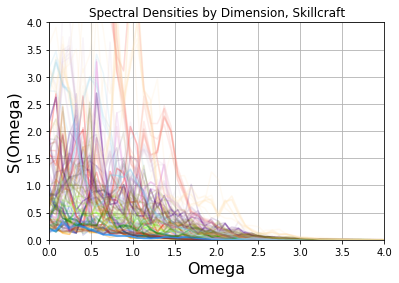

In [25]:
colors = ['navy', 'orange', 'teal', 'red', 'royalblue', 'goldenrod', 'firebrick', 'chartreuse',
         'dodgerblue', 'green', 'orchid', 'peru', 'dimgray', 'salmon', 'indigo', 'thistle',
         'skyblue', 'olive', 'moccasin']

for dim in range(in_dims):
    # get last 10 samples for current dimension
    dim_samples = alt_sampler.gsampled[dim][0, :,-10:]
    
    omega = model.covar_module.get_omega(dim).cpu().numpy()
    
    plt.plot(omega, dim_samples.exp().cpu().numpy(), color=colors[dim], alpha = 0.15)
plt.grid()

plt.xlabel('Omega', fontsize=16)
plt.ylabel('S(Omega)', fontsize = 16)
plt.xlim((0, 4))
plt.ylim((0, 4))
plt.title('Spectral Densities by Dimension, Skillcraft')